In [3]:
import matplotlib
import  pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

## Initilization

In [309]:
regexp_stat = re.compile(r'analizo_(.)*_(mean|sum)')
regexp_total = re.compile(r'analizo_total_(.)*')
rep_df_2d = pd.read_csv('data/robo2d-18_09_2018.csv')
rep_df_3d = pd.read_csv('data/3D-analysis-16_09_2018.csv')
#rep_df = pd.concat([rep_df_2d,rep_df_3d],sort=False)
code_df = rep_df_2d[rep_df_2d['is_source']==True]

In [310]:
code_df = code_df.rename(index=str,columns={'new_dir':'folder'})
code_df_reduced = code_df[[c for c in code_df.columns if regexp_stat.search(c) or regexp_total.search(c) or c == 'folder']].copy()
code_df_reduced['type_original'] = 'robo'
code_df_reduced.dropna(inplace=True)

In [421]:
df1 = pd.read_csv(os.getcwd() +"/data/git-hub-20_09_2018code_analysis__summery_report.csv")
df2 = pd.read_csv(os.getcwd() +"/data/anac-20_09_2018code_analysis__summery_report.csv")
df2['type'] = 'robo'
df_all = pd.concat([df1,df2])

In [422]:
GH_df = df_all[[c for c in df_all.columns if regexp_stat.search(c) or regexp_total.search(c) or c in ['folder','type']]].copy()
GH_df.rename(columns={'type':'type_original'},inplace=True)

In [423]:
GH_df_group_by = GH_df.groupby('type_original').count()

In [424]:
GH_df_group_by_50 = GH_df_group_by[GH_df_group_by.folder>1]

In [425]:
GH_df = GH_df[GH_df['type_original'].isin(GH_df_group_by_50.index.values)]

## Removing ACCM outliners 

In [426]:
low = .01
high = .97
quant_df = GH_df['analizo_accm_mean'].quantile([low, high])
quant_df

0.01    0.475532
0.97    5.392609
Name: analizo_accm_mean, dtype: float64

In [427]:
GH_df_reduced =GH_df.loc[(GH_df['analizo_accm_mean']>=quant_df[low]) & (GH_df['analizo_accm_mean']<=quant_df[high]),:]

In [431]:
df_merged= pd.concat([code_df_reduced,GH_df_reduced],sort=False)
df_merged['type'] = 'others'

In [432]:
df_merged.fillna(0,inplace=True)

In [433]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [434]:
import collections
def calculate_accurarcy(df,pred,Y,code_class):
    df_merged_acc = df.groupby('type_wrong').count().iloc[:,1]
    print df_merged_acc
    pred_robo_cont = collections.Counter(pred)[code_class]
    Y_robo_cont = collections.Counter(Y)[code_class]
    #calculate accurarcy 
    true_pos = float(df_merged_acc.loc[code_class]) if code_class in df_merged_acc.index else 0.0
    
    prec = true_pos / pred_robo_cont if pred_robo_cont >0 else 0 
    recall = true_pos / Y_robo_cont if Y_robo_cont > 0  else 0 
    print 'prec : '  , prec , 'recall :'  , recall , 'f1 :' , (2*(prec*recall)/(prec+recall)) if prec+recall >0 else 0
    
def set_wrong_type(pred,Y,df,type_class):
    df.loc[:,'wrong'] = False
    df.loc[(pred != Y),'wrong'] = True
    df.loc[(pred != Y) & (df['type'] == type_class),'type_wrong'] = 'wrong_' +type_class    
    df.loc[(pred == Y) & (df['type'] == type_class),'type_wrong'] = type_class
    df.loc[(pred != Y) & (df['type'] == 'others'),'type_wrong'] = 'wrong_others'
    df.loc[(pred == Y) & (df['type'] == 'others'),'type_wrong'] = 'others'
    return df
def classify_one_vs_many(df,type_class):   
    GH_df_reduced_one_vs_many = df.copy()
    GH_df_reduced_one_vs_many.loc[GH_df_reduced_one_vs_many['type_original']==type_class,'type' ] = type_class
    print GH_df_reduced_one_vs_many.groupby('type').count().iloc[:,1]
    X = GH_df_reduced_one_vs_many.select_dtypes(include=[np.number])
    Y = GH_df_reduced_one_vs_many.loc[:,'type']
    # feature extraction
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    fitl= model.fit(X,Y)
    model.score(X,Y)
    rfe = RFE(model, 2)
    fit = rfe.fit(X, Y)
    print "Selected features : " + str(X.columns[fit.support_])
    pred = model.predict(X)
    df_accurarcy  = set_wrong_type(pred,Y,GH_df_reduced_one_vs_many,type_class)
    calculate_accurarcy(df_accurarcy,pred,Y,type_class)
    return df_accurarcy , X.columns[fit.support_].values

# Accurercy : 

robo
type
others    483
robo      169
Name: analizo_acc_sum, dtype: int64
Selected features : Index([u'analizo_accm_mean', u'analizo_total_cof'], dtype='object')
type_wrong
others          463
robo            121
wrong_others     20
wrong_robo       48
Name: analizo_acc_sum, dtype: int64
prec :  0.858156028369 recall : 0.715976331361 f1 : 0.78064516129
------------------

Security
type
Security     60
others      592
Name: analizo_acc_sum, dtype: int64
Selected features : Index([u'analizo_anpm_mean', u'analizo_total_cof'], dtype='object')
type_wrong
Security            4
others            589
wrong_Security     56
wrong_others        3
Name: analizo_acc_sum, dtype: int64
prec :  0.571428571429 recall : 0.0666666666667 f1 : 0.119402985075
------------------

mobile
type
mobile     52
others    600
Name: analizo_acc_sum, dtype: int64
Selected features : Index([u'analizo_dit_mean', u'analizo_noc_mean'], dtype='object')
type_wrong
others          600
wrong_mobile     52
Name: analizo_acc_s

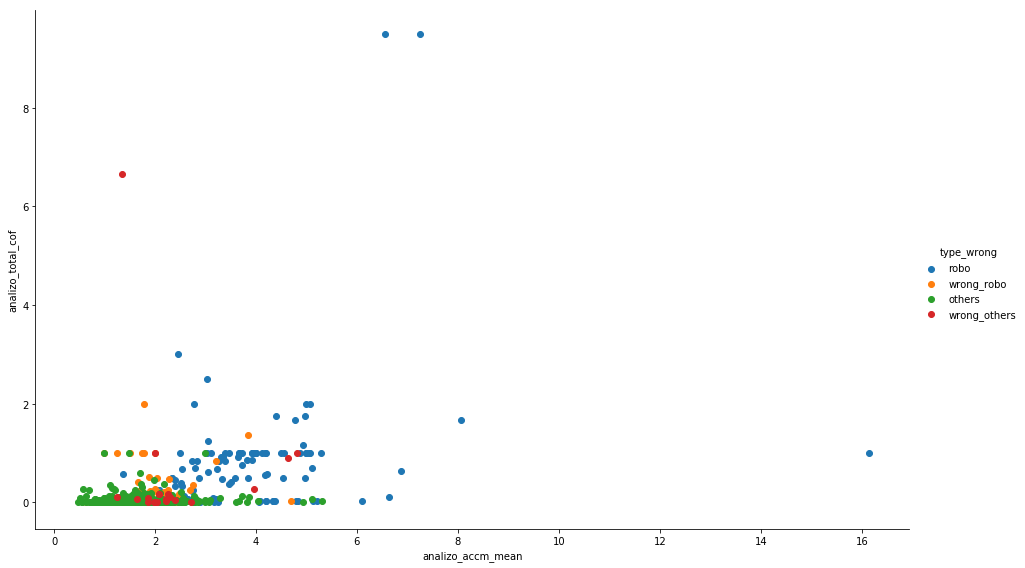

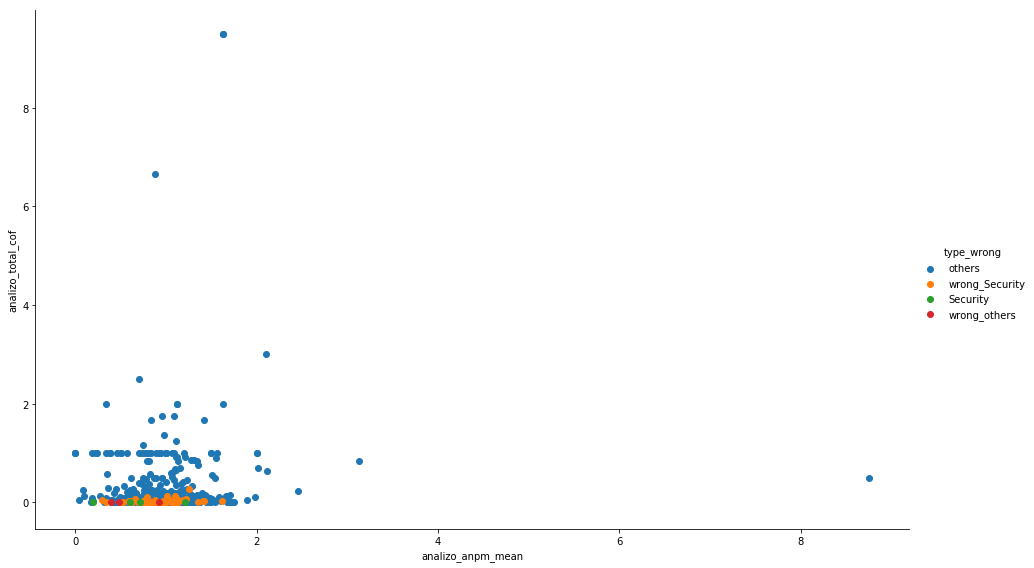

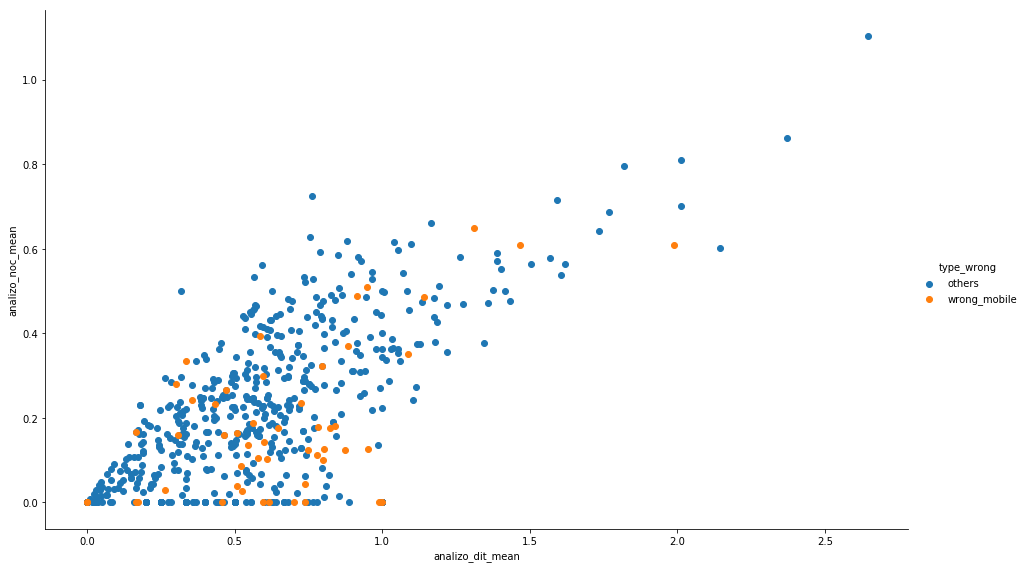

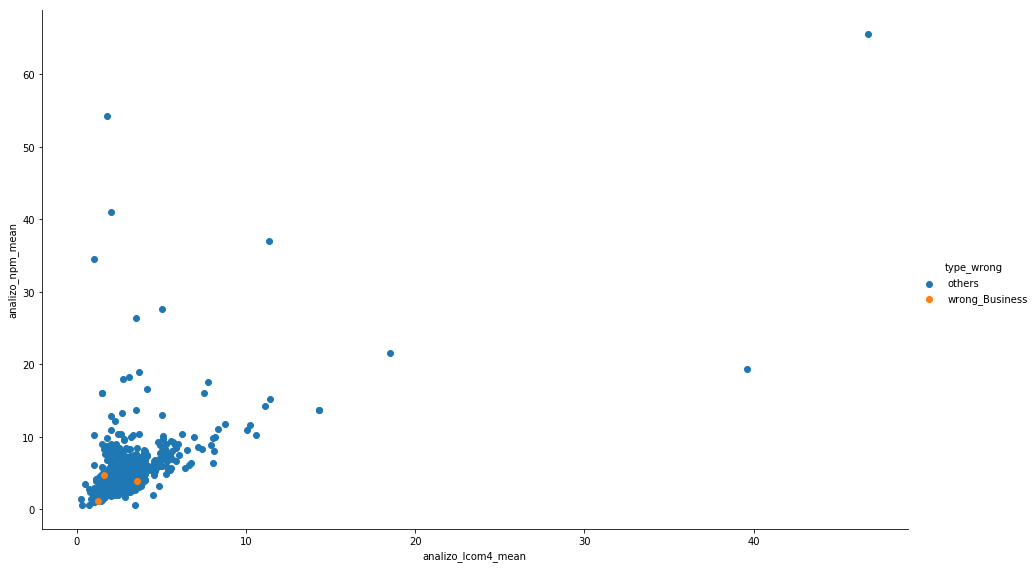

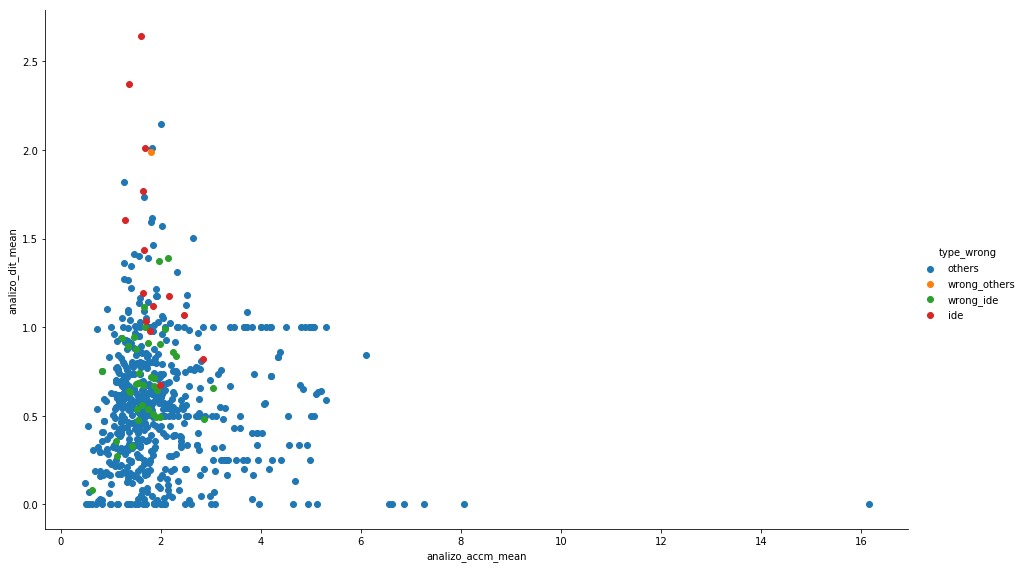

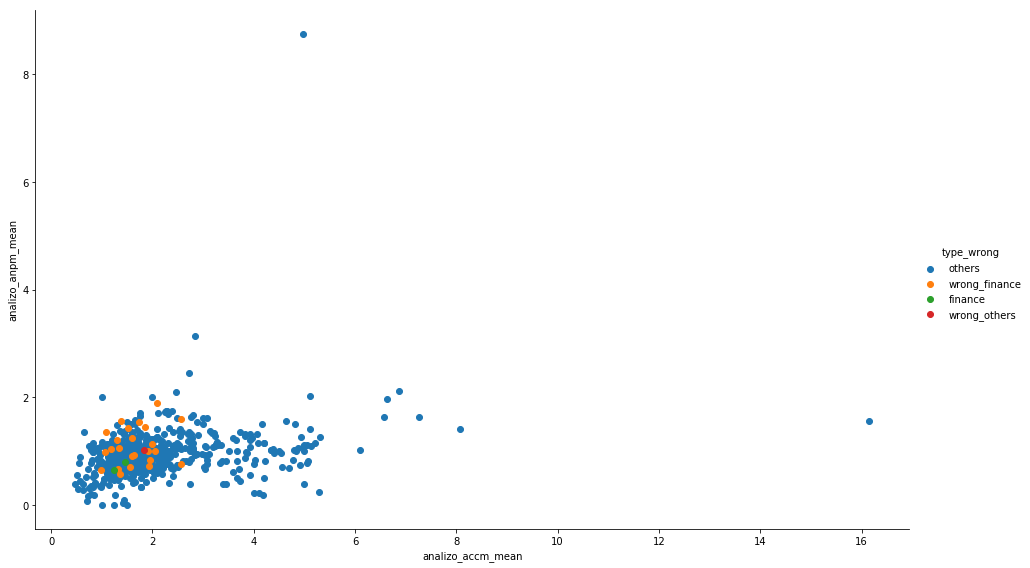

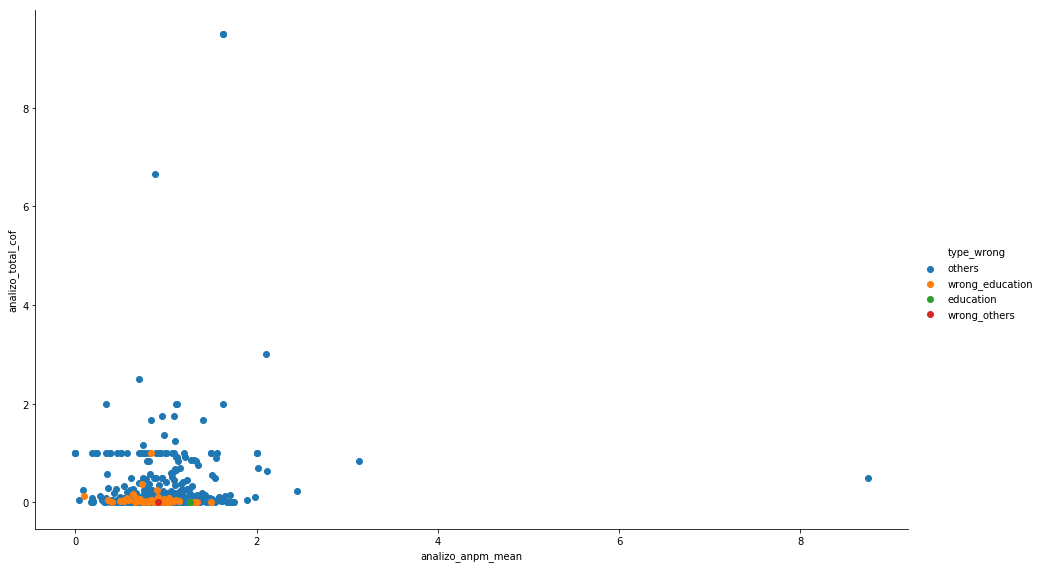

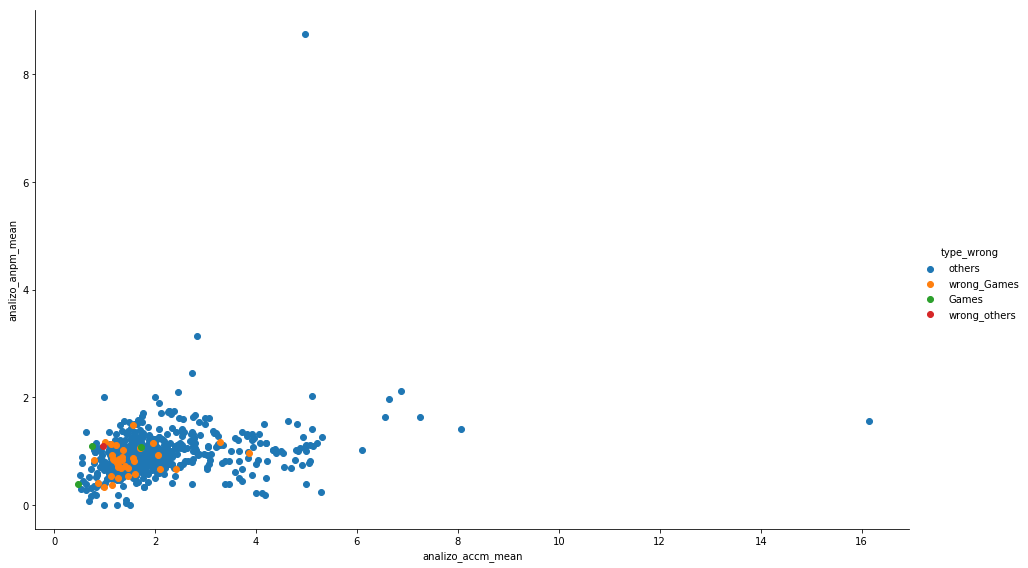

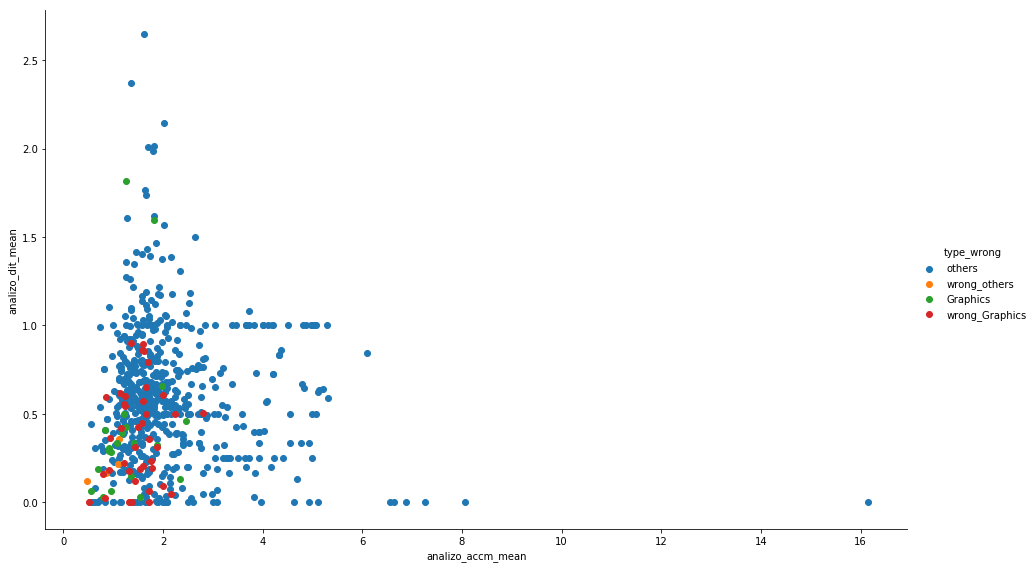

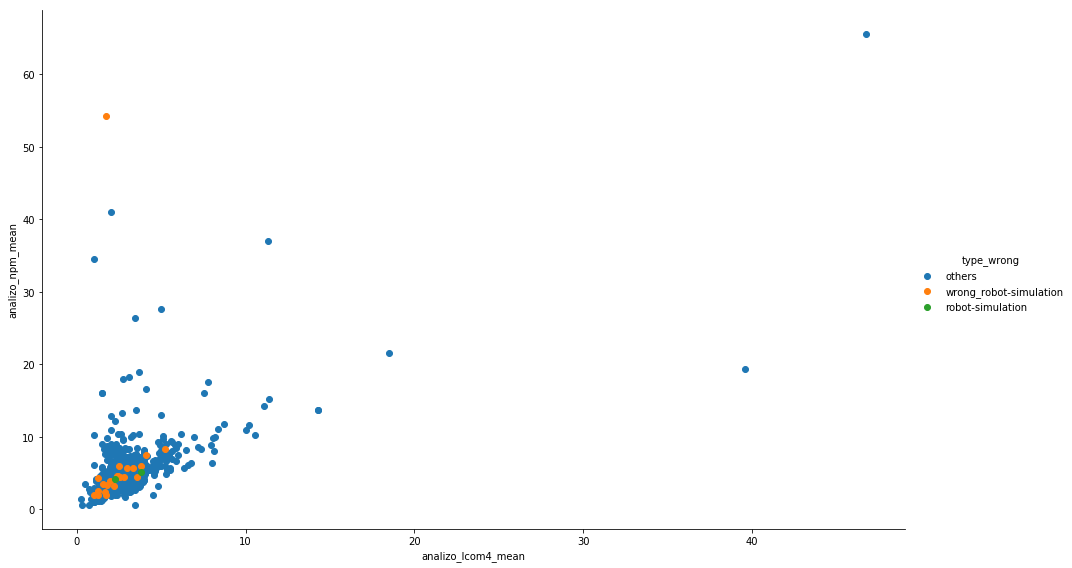

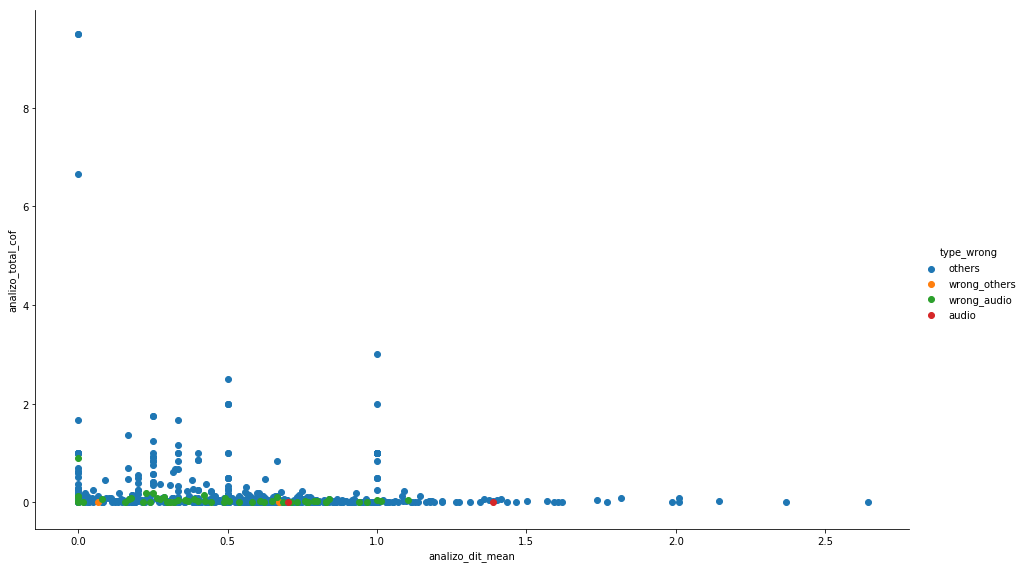

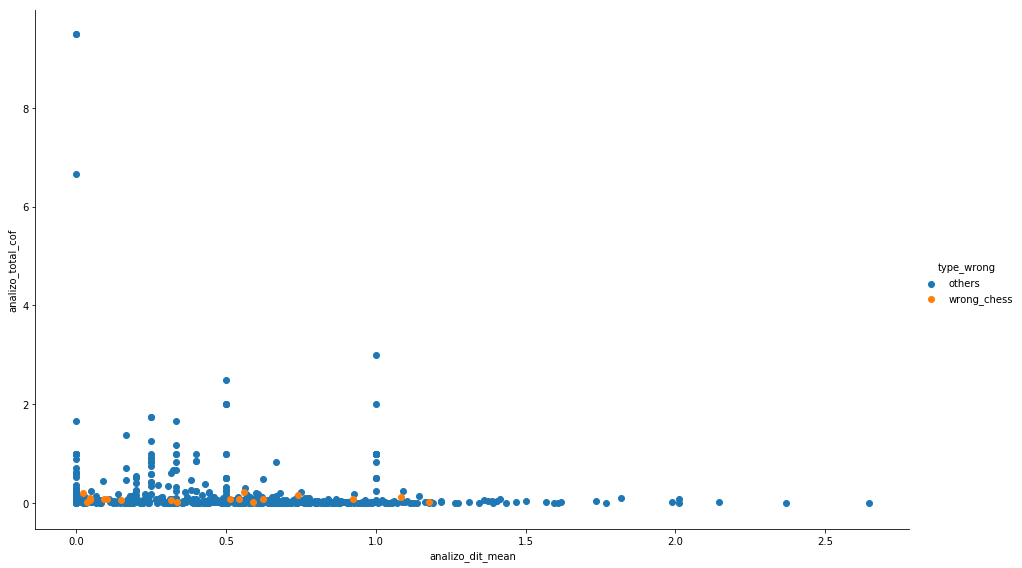

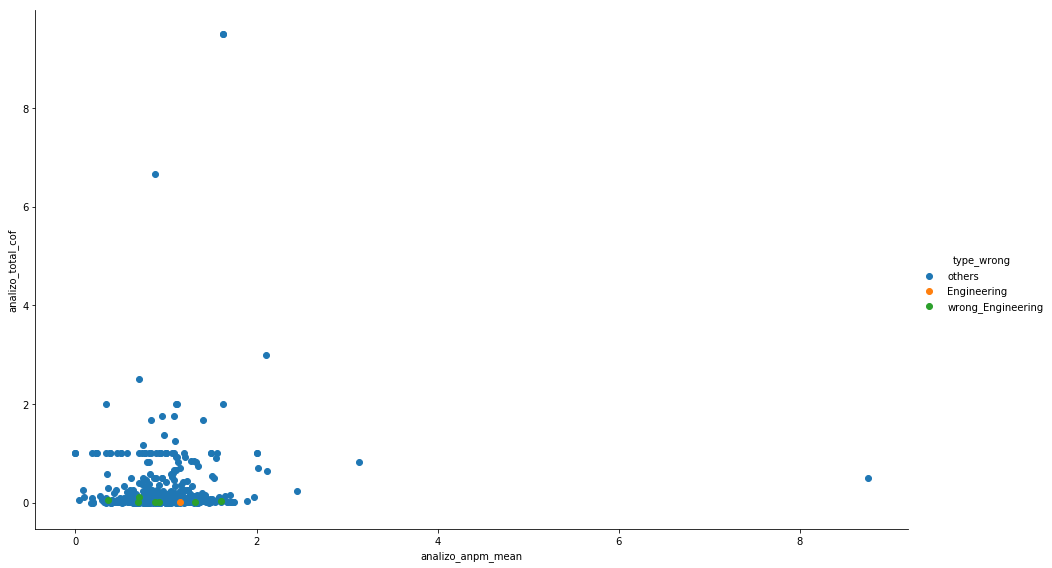

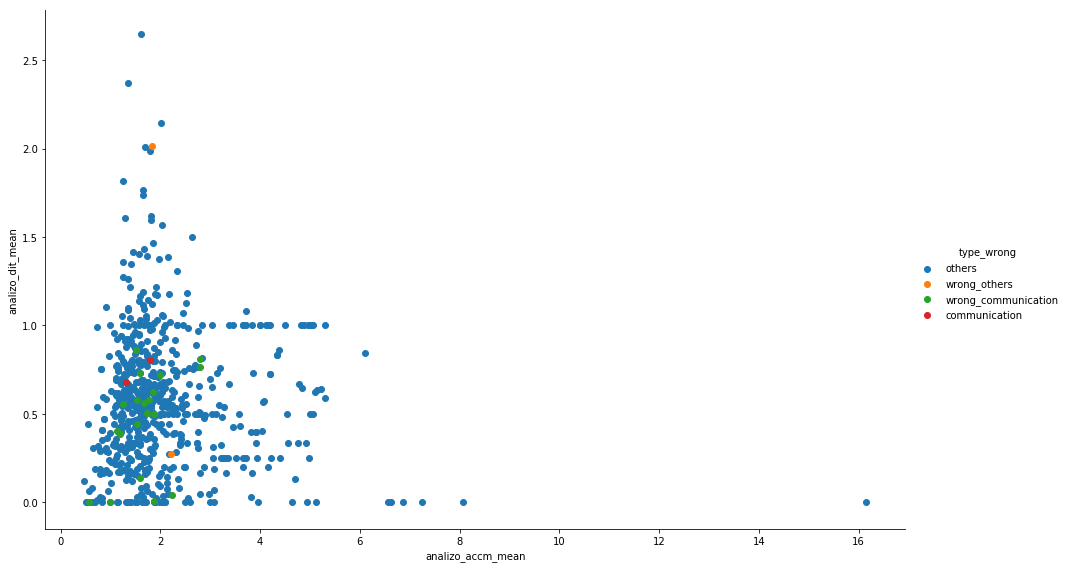

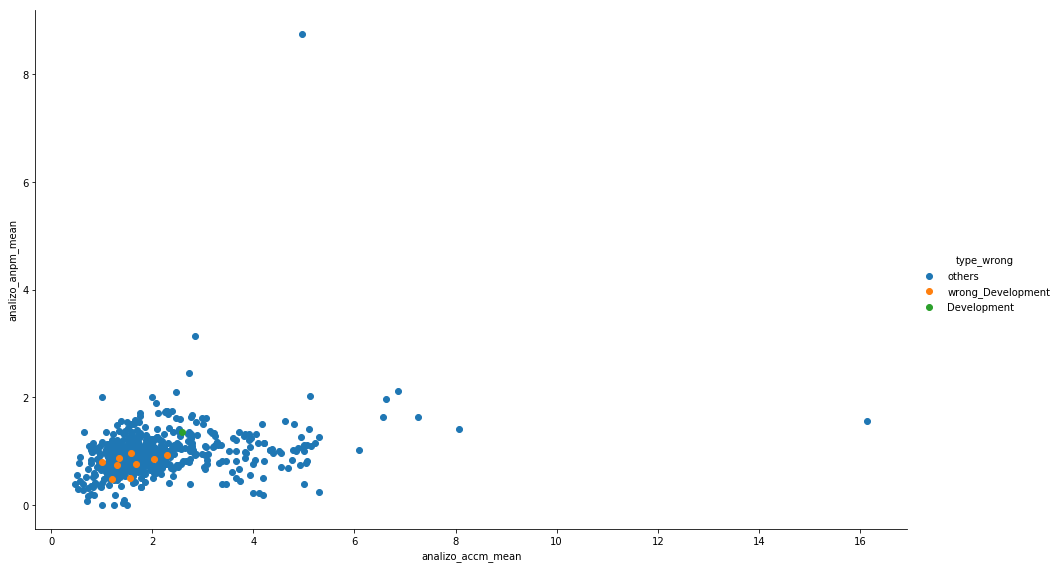

In [439]:
for t in df_merged['type_original'].unique():
    print t
    type_class =  t
    df_accurarcy, selected_features = classify_one_vs_many(df_merged,type_class)
    fg = sns.FacetGrid(data=df_accurarcy, hue='type_wrong',  aspect=1.61,height=8)
    fig = fg.map(plt.scatter, selected_features[0],selected_features[1],).add_legend()
   
    print '------------------\n'

In [444]:
df_accurarcy, selected_features = classify_one_vs_many(df_merged[['type','type_original','analizo_accm_mean','analizo_total_cof']],'robo')

type
others    483
robo      169
Name: analizo_accm_mean, dtype: int64
Selected features : Index([u'analizo_accm_mean', u'analizo_total_cof'], dtype='object')
type_wrong
others          467
robo             84
wrong_others     16
wrong_robo       85
Name: type_original, dtype: int64
prec :  0.84 recall : 0.497041420118 f1 : 0.624535315985


In [217]:
import pickle

In [218]:
pickle.dump(model,open('dump','w'))